In [71]:
import numpy as np
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score

# import directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### ETL

The following functions are the ETL functions used to take the original data, create features (based on the history of various parts such as invoices, revenue, etc) and convert to a format readable by a machine learning algorithm. The target is the revenue 30 days after the target date - this is a regression problem.

In [3]:
import os
import sys
import re
import shutil
import time
import pickle
from collections import defaultdict
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def fetch_data(data_dir):
    """
    laod all json formatted files into a dataframe
    """

    ## input testing
    if not os.path.isdir(data_dir):
        raise Exception("specified data dir does not exist")
    if not len(os.listdir(data_dir)) > 0:
        raise Exception("specified data dir does not contain any files")

    file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]
    correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month',
                       'price', 'stream_id', 'times_viewed', 'year']

    ## read data into a temp structure
    all_months = {}
    for file_name in file_list:
        df = pd.read_json(file_name)
        all_months[os.path.split(file_name)[-1]] = df

    ## ensure the data are formatted with correct columns
    for f,df in all_months.items():
        cols = set(df.columns.tolist())
        if 'StreamID' in cols:
             df.rename(columns={'StreamID':'stream_id'},inplace=True)
        if 'TimesViewed' in cols:
            df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
        if 'total_price' in cols:
            df.rename(columns={'total_price':'price'},inplace=True)

        cols = df.columns.tolist()
        if sorted(cols) != correct_columns:
            raise Exception("columns name could not be matched to correct cols")

    ## concat all of the data
    df = pd.concat(list(all_months.values()),sort=True)
    years,months,days = df['year'].values,df['month'].values,df['day'].values 
    dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
    df['invoice_date'] = np.array(dates,dtype='datetime64[D]')
    df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]
    
    ## sort by date and reset the index
    df.sort_values(by='invoice_date',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    return(df)

def convert_to_ts(df_orig, country=None):
    """
    given the original DataFrame (fetch_data())
    return a numerically indexed time-series DataFrame 
    by aggregating over each day
    """

    if country:
        if country not in np.unique(df_orig['country'].values):
            raise Exception("country not found")
    
        mask = df_orig['country'] == country
        df = df_orig[mask]
    else:
        df = df_orig
        
    ## use a date range to ensure all days are accounted for in the data
    invoice_dates = df['invoice_date'].values
    start_month = '{}-{}'.format(df['year'].values[0],str(df['month'].values[0]).zfill(2))
    stop_month = '{}-{}'.format(df['year'].values[-1],str(df['month'].values[-1]).zfill(2))
    df_dates = df['invoice_date'].values.astype('datetime64[D]')
    days = np.arange(start_month, stop_month, dtype='datetime64[D]')
    
    purchases = np.array([np.where(df_dates==day)[0].size for day in days])
    invoices = [np.unique(df[df_dates==day]['invoice'].values).size for day in days]
    streams = [np.unique(df[df_dates==day]['stream_id'].values).size for day in days]
    views =  [df[df_dates==day]['times_viewed'].values.sum() for day in days]
    revenue = [df[df_dates==day]['price'].values.sum() for day in days]
    year_month = ["-".join(re.split("-",str(day))[:2]) for day in days]
    
    

    df_time = pd.DataFrame({'date':days,
                            'purchases':purchases,
                            'unique_invoices':invoices,
                            'unique_streams':streams,
                            'total_views':views,
                            'year_month':year_month,
                            'revenue':revenue})
    
    # new - month and year
    df_time['month'] = df_time['year_month'].str.split('-').apply(lambda x: x[1]).astype(int)
    df_time['year'] =  df_time['year_month'].str.split('-').apply(lambda x: x[0]).astype(int)    
    
    return(df_time)

In [4]:
def save_ts(datadir):
    
    def revise_ts(df_time):
        """
        Add type of data - train or production data. Training data is until 8/1/2019 
        """
        df_time['type'] = ''
        df_time.loc[(((df_time['year'] == 2019) & (df_time['month'] >= 8)) | (df_time['year'] > 2019)), 'type'] = 'prod'
        df_time.loc[(df_time['type'] != 'prod'), 'type'] = 'train'
        return df_time
    
    train_datadir = os.path.join(datadir, "cs-train")
    prod_datadir = os.path.join(datadir, "cs-production")
    ts_datadir = os.path.join(datadir, 'ts-data')
    
    # wipe old files
    shutil.rmtree(ts_datadir)
    if not os.path.exists(ts_datadir):
        os.mkdir(ts_datadir)

    df_train = fetch_data(train_datadir)
    df_prod = fetch_data(prod_datadir)
    
    df_train['type'] = 'train'
    df_prod['type'] = 'prod'
    df = pd.concat([df_train, df_prod])
    
    ## find the top N countries (wrt revenue)
    N = 15
    table = pd.pivot_table(df,index='country', values="price", aggfunc='sum')
    table.columns = ['total_revenue']
    table.sort_values(by='total_revenue',inplace=True,ascending=False)
    top_countries =  np.array(list(table.index))[:N].tolist()
    
    for country in top_countries:    
        df_time = convert_to_ts(df, country=country)
        df_time = revise_ts(df_time)
        ts_filename = os.path.join(ts_datadir, f"{country.lower()}.csv")
        df_time.to_csv(ts_filename, index=False)

    return df

def load_ts(datadir, country=None, datatype='all', droptype=False):
    """
    datatypes: all, train, or prod in string format
    """    
    
    ts_datadir = os.path.join(datadir, 'ts-data')
    
    if country:
        c = country.lower()
        onlyfiles = [f for f in os.listdir(ts_datadir) if os.path.isfile(os.path.join(ts_datadir, f))]
        countries_in_dir = [c.split('.')[0] for c in onlyfiles]
        if c not in countries_in_dir:
            raise Exception("country not found")
    
    filename = os.path.join(ts_datadir, f'{c}.csv')
    df_ts = pd.read_csv(filename)
    if datatype.lower() == 'train':
        df_ts = df_ts[df_ts['type'] == 'train']        
    elif datatype.lower() == 'prod':
        df_ts = df_ts[df_ts['type'] == 'prod']
    elif datatype.lower() == 'all':
        # all data
        pass
    else:
        # all data
        raise Exception("datatype must be train, prod, or all")
    
    # remove type column
    if droptype:
        df_ts = df_ts.drop(columns=['type'])
    return df_ts

This is the function to engineer the various features to feed into a machine learning algorithm.

In [5]:
def engineer_features(df, datatype='all', log=True):
    """
    df: country based time series
    datatypes: all, train, or prod in string format
    """
    def refactor_original(df, remove_early=True):
        
        columns_p1 = ["date", "purchases", "unique_invoices", "unique_streams", "total_views", "year_month"]
        columns_p2 = ["type", "revenue"]
        df = pd.concat([df[columns_p1], pd.get_dummies(df.month, prefix='month'),
                            pd.get_dummies(df.year, prefix='year'), df[columns_p2]], axis=1)

        # add months as new variables if not in variables
        for i in range(1, 13):
            month = f'month_{i:02d}'
            if month not in df.columns:
                df[month] = 0
                df[month] = df[month].astype(int)

        # add years as new variables if not in variables
        for i in range(2017, 2020):
            year = f'year_{i}'
            if year not in df.columns:
                df[year] = 0
                df[year] = df[year].astype(int)


        df = df[['date', 'purchases', 'unique_invoices', 'unique_streams', 'total_views',
                 'month_01', 'month_02', 'month_03', 'month_04', 'month_05', 'month_06',
                 'month_07', 'month_08', 'month_09', 'month_10', 'month_11', 'month_12',
                 'year_2017', 'year_2018', 'year_2019',
                 'type', 'revenue']]
        return df
    
    if datatype.lower() not in ['train', 'prod', 'all']:
        raise Exception("datatype must be train, prod, or all")
    
    
    # refactor
    df = refactor_original(df)
    
    ## extract dates
    dates = df['date'].values.copy()
    dates = dates.astype('datetime64[D]')
    
    ## engineer some features
    eng_features = defaultdict(list)
    
    # [7, 14, 21, 28, 35, 42, 49, 56, 63, 70]
    # [7, 14, 28, 70]
    previous = [7, 14, 28, 70]
    y = np.zeros(dates.size)
    # first is date, last is revenue
    variables = ['purchases', 'unique_invoices', 'unique_streams', 'total_views', 'revenue']
    months = [f'month_{i:02d}' for i in range(1, 13)]
    years = [f'year_{i}' for i in range(2017, 2020)]
    
    for d,day in enumerate(dates):
        # current day
        current = np.datetime64(day, 'D')
        
        ## get the target revenue    
        plus_30 = current + np.timedelta64(30,'D')
        mask = np.in1d(dates, np.arange(current,plus_30,dtype='datetime64[D]'))
        y[d] = df[mask]['revenue'].sum()

        # time-based features
        for variable in variables:
            ## use windows in time back from a specific date
            for num in previous:
                prev = current - np.timedelta64(num, 'D')
                mask = np.in1d(dates, np.arange(prev, current, dtype='datetime64[D]'))
                sum_var = df[mask][variable].sum()
                eng_features[f"previous_{num}_{variable}"].append(sum_var)
                                
            ## attempt to capture monthly trend with previous years data (if present)
            start_date = current - np.timedelta64(365,'D')
            stop_date = plus_30 - np.timedelta64(365,'D')
            mask = np.in1d(dates, np.arange(start_date, stop_date,dtype='datetime64[D]'))
            eng_features[f'previous_year_{variable}'].append(df[mask][variable].sum())

        # get type
        mask = np.in1d(dates, np.arange(current,current+1,dtype='datetime64[D]'))
        var = df.loc[mask, "type"].values[0]
        eng_features["type"].append(var)

    X = pd.DataFrame(eng_features)

    # prune data depending on type
    if datatype.lower() == 'train':
        dates = dates[X['type'] == 'train']
        y = y[X['type'] == 'train']
        X = X[X['type'] == 'train']
    elif datatype.lower() == 'prod':
        dates = dates[X['type'] == 'prod']
        y = y[X['type'] == 'prod']
        X = X[X['type'] == 'prod']
    elif datatype.lower() == 'all':
        # all data
        pass
    else:
        # all data
        raise Exception("datatype must be train, prod, or all")
        
    # drop type
    X = X.drop(columns=['type'])

    ## combine features in to df and remove rows with all zeros
    X.fillna(0, inplace=True)
    mask = X.sum(axis=1)>0
    X = X[mask]
    y = y[mask]
    dates = dates[mask]
    X.reset_index(drop=True, inplace=True)

    ## remove the last 30 days (because the target is not reliable)
    mask = np.arange(X.shape[0]) < np.arange(X.shape[0])[-30]
    X = X[mask]
    y = y[mask]
    dates = dates[mask]
    X.reset_index(drop=True, inplace=True)
    
    if log:
        y = np.log(y)
    
    return X, y, dates

These are hte data directories and application of the feeding of the JSON files into time series CSVs. We will ultimately create models for the top 10 - 15 countries in total revenue.

In [6]:
datadir = os.path.join(module_path, "src", "app", "data")

train_datadir = os.path.join(datadir, "cs-train")
prod_datadir = os.path.join(datadir, "cs-production")

In [7]:
# parameters
country = 'United Kingdom'

dfi = load_ts(datadir, country=country, datatype='all', droptype=False)

dfi_train = dfi[dfi['type'] == 'train']
dfi_prod = dfi[dfi['type'] == 'prod']

In [8]:
dfi.head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue,month,year,type
0,2017-11-01,0,0,0,0,2017-11,0.0,11,2017,train
1,2017-11-02,0,0,0,0,2017-11,0.0,11,2017,train
2,2017-11-03,0,0,0,0,2017-11,0.0,11,2017,train
3,2017-11-04,0,0,0,0,2017-11,0.0,11,2017,train
4,2017-11-05,0,0,0,0,2017-11,0.0,11,2017,train


## Ridge Regression

We'll select from one of three models - a linear model (Ridge Regression), a support vector machine, and random forest.

In [9]:
log = True
X_train, y_train, dates_train = engineer_features(dfi, datatype='train', log=log)

print(dfi_train.shape, X_train.shape)

(638, 10) (580, 25)


In [10]:
alphas = np.power(10, np.arange(-4, 2, dtype=float))

param_grid = {'alpha': alphas, 'normalize': [True, False]}

In [11]:
lm = Ridge(random_state=42)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf = GridSearchCV(lm, param_grid=param_grid, cv=3)


In [12]:
# Fit the random search model
clf.fit(X_train, y_train)
# Make predictions on traibning data
y_train_pred = clf.predict(X_train)

# get revenue
if log:
    r_train = np.exp(y_train)
    r_train_pred = np.exp(y_train_pred)
else:
    r_train = y_train
    r_train_pred = y_train_pred

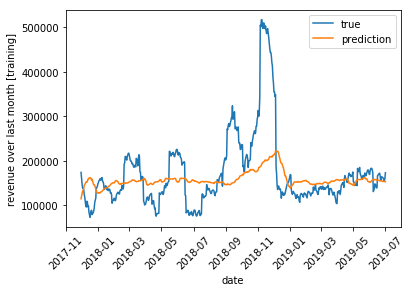

In [13]:
plt.plot(dates_train, r_train, label='true')
plt.plot(dates_train, r_train_pred, label='prediction')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel('date')
plt.ylabel('revenue over last month [training]')
plt.legend()
plt.show()

In [14]:
X_prod, y_prod, dates_prod = engineer_features(dfi, datatype='prod', log=log)

print(dfi_prod.shape, X_prod.shape)

(122, 10) (92, 25)


In [15]:
y_prod_pred = clf.predict(X_prod)

# get revenue
if log:
    r_prod = np.exp(y_prod)
    r_prod_pred = np.exp(y_prod_pred)
else:
    r_prod = y_prod
    r_prod_pred = y_prod_pred

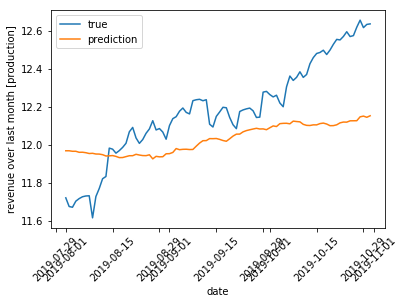

In [16]:
plt.plot(dates_prod, y_prod, label='true')
plt.plot(dates_prod, y_prod_pred, label='prediction')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel('date')
plt.ylabel('revenue over last month [production]')
plt.legend()
plt.show()

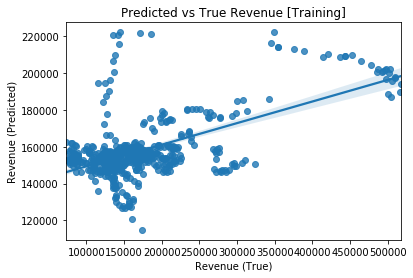

rmse: 76633.7172787395
r-squared: 0.17068933067444825


In [17]:
sns.regplot(x=r_train, y=r_train_pred)
plt.xlabel("Revenue (True)")
plt.ylabel("Revenue (Predicted)")
plt.title("Predicted vs True Revenue [Training]")
plt.show()

print(f"rmse: {np.sqrt(mean_squared_error(r_train, r_train_pred))}\nr-squared: {r2_score(r_train, r_train_pred)}")

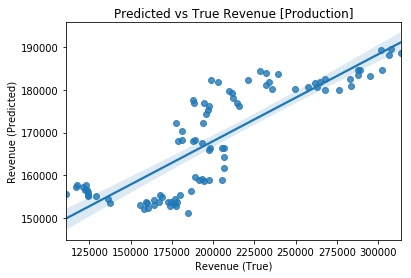

rmse: 52863.74902640621
r-squared: -0.06451696008284435


In [18]:
sns.regplot(x=r_prod, y=r_prod_pred)
plt.xlabel("Revenue (True)")
plt.ylabel("Revenue (Predicted)")
plt.title("Predicted vs True Revenue [Production]")
plt.show()

print(f"rmse: {np.sqrt(mean_squared_error(r_prod, r_prod_pred))}\nr-squared: {r2_score(r_prod, r_prod_pred)}")

## Support Vector Machine

In [19]:
log = False
X_train, y_train, dates_train = engineer_features(dfi, datatype='train', log=log)

print(dfi_train.shape, X_train.shape)

(638, 10) (580, 25)


In [103]:
param_grid = { 'svr__C':[0.0001, 0.001, 0.01, 0.1,1,100, 1000],
              'svr__kernel':['rbf'],
              'svr__gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001]
             }


In [104]:
svm = make_pipeline(StandardScaler(), SVR())


clf = GridSearchCV(svm, param_grid=param_grid, cv=3)

In [105]:
# Fit the random search model
clf.fit(X_train, y_train)
# Make predictions on traibning data
y_train_pred = clf.predict(X_train)

# get revenue
if log:
    r_train = np.exp(y_train)
    r_train_pred = np.exp(y_train_pred)
else:
    r_train = y_train
    r_train_pred = y_train_pred

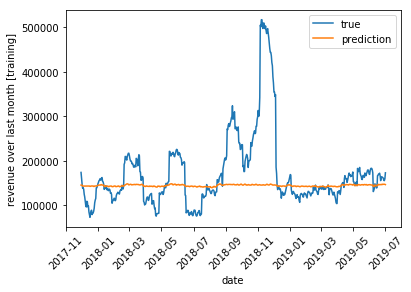

In [106]:
plt.plot(dates_train, r_train, label='true')
plt.plot(dates_train, r_train_pred, label='prediction')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel('date')
plt.ylabel('revenue over last month [training]')
plt.legend()
plt.show()

In [107]:
X_prod, y_prod, dates_prod = engineer_features(dfi, datatype='prod', log=log)

print(dfi_prod.shape, X_prod.shape)

(122, 10) (92, 25)


In [108]:
y_prod_pred = clf.predict(X_prod)

# get revenue
if log:
    r_prod = np.exp(y_prod)
    r_prod_pred = np.exp(y_prod_pred)
else:
    r_prod = y_prod
    r_prod_pred = y_prod_pred

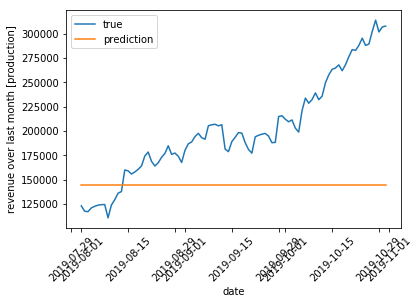

In [109]:
plt.plot(dates_prod, y_prod, label='true')
plt.plot(dates_prod, y_prod_pred, label='prediction')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel('date')
plt.ylabel('revenue over last month [production]')
plt.legend()
plt.show()

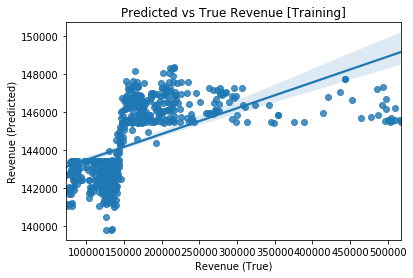

rmse: 87227.82147581887
r-squared: -0.07445324044340929


In [110]:
sns.regplot(x=r_train, y=r_train_pred)
plt.xlabel("Revenue (True)")
plt.ylabel("Revenue (Predicted)")
plt.title("Predicted vs True Revenue [Training]")
plt.show()

print(f"rmse: {np.sqrt(mean_squared_error(r_train, r_train_pred))}\nr-squared: {r2_score(r_train, r_train_pred)}")

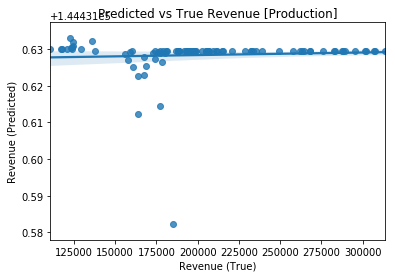

rmse: 76444.79627268338
r-squared: -1.226037731209134


In [111]:
sns.regplot(x=r_prod, y=r_prod_pred)
plt.xlabel("Revenue (True)")
plt.ylabel("Revenue (Predicted)")
plt.title("Predicted vs True Revenue [Production]")
plt.show()

print(f"rmse: {np.sqrt(mean_squared_error(r_prod, r_prod_pred))}\nr-squared: {r2_score(r_prod, r_prod_pred)}")

## Random Forest

In [112]:
log=False
X_train, y_train, dates_train = engineer_features(dfi, datatype='train', log=log)

print(dfi_train.shape, X_train.shape)

(638, 10) (580, 25)


In [113]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [114]:
rf = RandomForestRegressor(random_state=42)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100,
                               cv=3, verbose=2, random_state=42, n_jobs = -1)

In [116]:
# Fit the random search model
clf.fit(X_train, y_train)
# Make predictions on traibning data
y_train_pred = clf.predict(X_train)

# get revenue
if log:
    r_train = np.exp(y_train)
    r_train_pred = np.exp(y_train_pred)
else:
    r_train = y_train
    r_train_pred = y_train_pred

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.5min finished


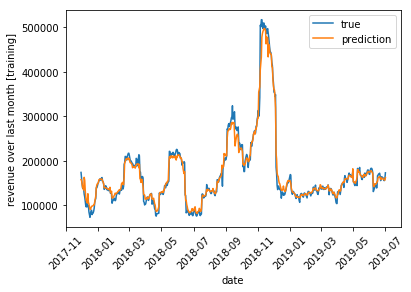

In [117]:
plt.plot(dates_train, r_train, label='true')
plt.plot(dates_train, r_train_pred, label='prediction')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel('date')
plt.ylabel('revenue over last month [training]')
plt.legend()
plt.show()

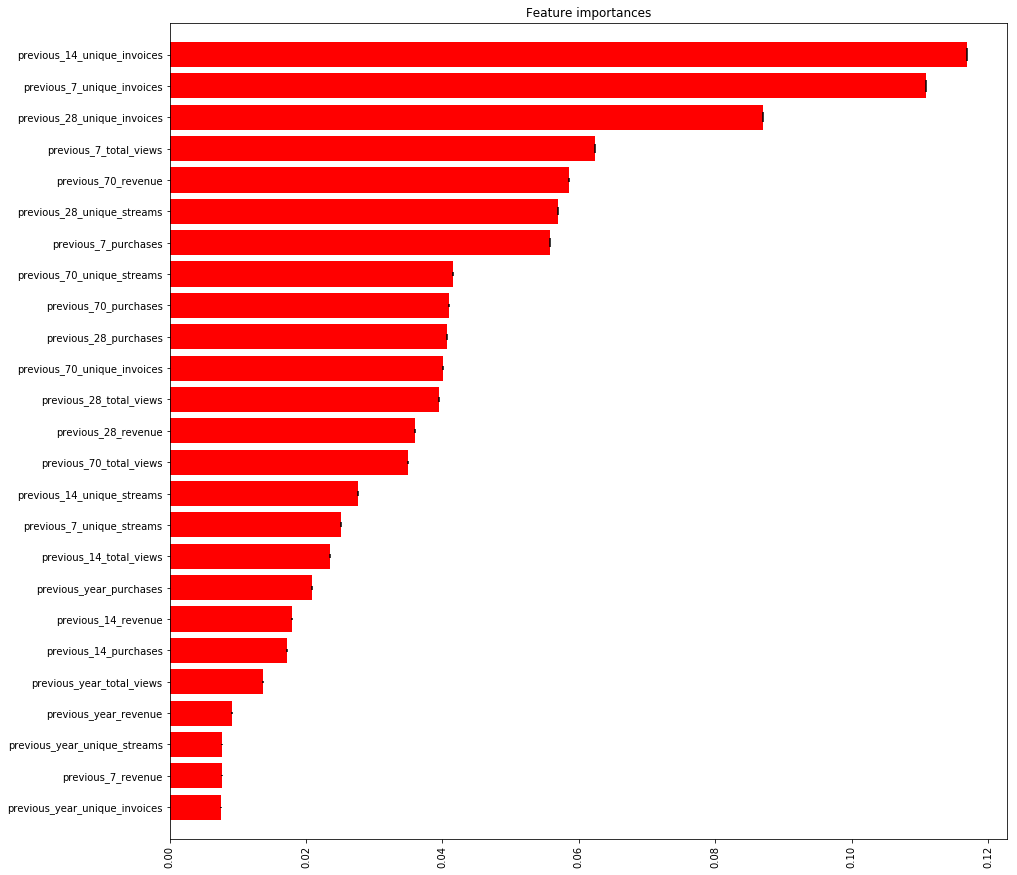

In [118]:
importances = clf.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(15,15))
plt.title("Feature importances")
columns = X_train.iloc[0, indices].index.tolist()


plt.barh(columns, importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(rotation=90)
plt.ylim([-1, X_train.shape[1]])
plt.show()

In [119]:
X_prod, y_prod, dates_prod = engineer_features(dfi, datatype='prod', log=log)

print(dfi_prod.shape, X_prod.shape)

(122, 10) (92, 25)


In [121]:
y_prod_pred = clf.predict(X_prod)

# get revenue
if log:
    r_prod = np.exp(y_prod)
    r_prod_pred = np.exp(y_prod_pred)
else:
    r_prod = y_prod
    r_prod_pred = y_prod_pred

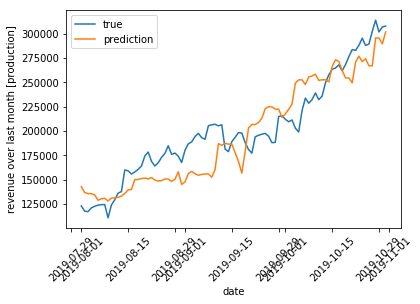

In [122]:
plt.plot(dates_prod, y_prod, label='true')
plt.plot(dates_prod, y_prod_pred, label='prediction')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.xlabel('date')
plt.ylabel('revenue over last month [production]')
plt.legend()
plt.show()

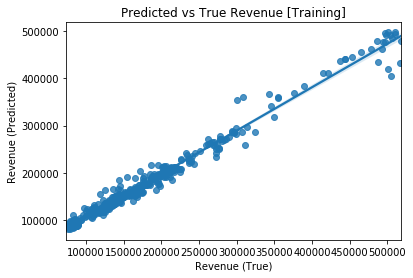

rmse: 12616.776388940256
r-squared: 0.9775211401366856


In [123]:
sns.regplot(x=r_train, y=r_train_pred)
plt.xlabel("Revenue (True)")
plt.ylabel("Revenue (Predicted)")
plt.title("Predicted vs True Revenue [Training]")
plt.show()

print(f"rmse: {np.sqrt(mean_squared_error(r_train, r_train_pred))}\nr-squared: {r2_score(r_train, r_train_pred)}")

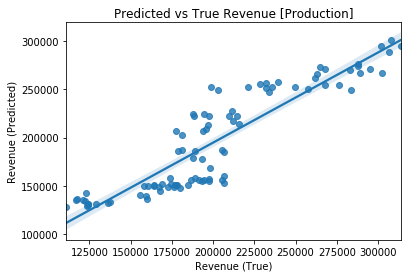

rmse: 23559.806063589247
r-squared: 0.788563437997205


In [124]:
sns.regplot(x=r_prod, y=r_prod_pred)
plt.xlabel("Revenue (True)")
plt.ylabel("Revenue (Predicted)")
plt.title("Predicted vs True Revenue [Production]")
plt.show()

print(f"rmse: {np.sqrt(mean_squared_error(r_prod, r_prod_pred))}\nr-squared: {r2_score(r_prod, r_prod_pred)}")

Based off these three models, I shall go with the random forest model based off of its performance.

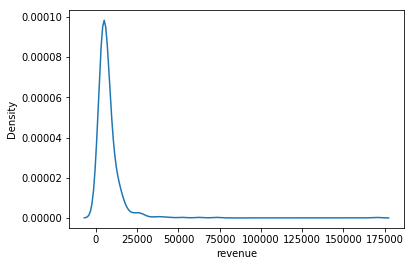

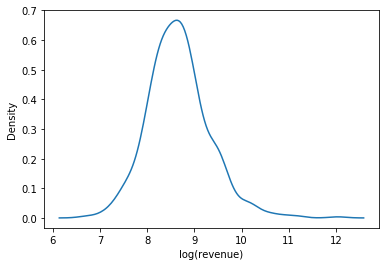

In [125]:
sns.kdeplot(dfi[dfi['revenue'] > 0]['revenue'])
plt.show()

sns.kdeplot(np.log(dfi[dfi['revenue'] > 0]['revenue']))
plt.xlabel("log(revenue)")
plt.show()